In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
from matplotlib import cm, colors
from adjustText import adjust_text

from math import pi
import math
import json

from scipy import stats as st
from sklearn.cluster import OPTICS
from sklearn.manifold import MDS

In [2]:
df = pd.read_csv('match_result/finalmatched_massonly.csv', index_col=None)
massdb = json.load(open('databases/hmdb_metabolites/hmdb_full.json'))
print(f'number of metabolite in dictionary = {len(massdb)}')

number of metabolite in dictionary = 217920


In [3]:
"""
a helper function to map colors depending on their increase or decrease
input 
    pivot table containing columns "Morning", "Afternoon", "Evening" and found_mass index
    
output
    dataframe with foldchange and the mapped colors
"""
def colour_mapping(pivotdf):
    
    outdf = pivotdf.copy()
    
    # calculate difference change
    outdf['morning_noon_FC'] = outdf['Afternoon'] - outdf['Morning']
    outdf['noon_evening_FC'] = outdf['Evening'] - outdf['Afternoon']
    
    # log2 diff
    #newdf['log2_morning_noon_FC'] = np.log(abs(newdf['morning_noon_FC']))
    #newdf['log2_noon_evening_FC'] = np.log(abs(newdf['noon_evening_FC']))
    
    # get the min and max log10 fold change
    min_log_FC = np.min(outdf.loc[:,['morning_noon_FC','noon_evening_FC']].values)
    max_log_FC = np.max(outdf.loc[:,['morning_noon_FC','noon_evening_FC']].values)

    # map the log fold changes to the coolwarm colormap
    # may need to change the vmin and vmax depending on the min_log_FC and max_log_FC for your data,
    # but make sure it's centered around 0 so that no change is mapped to grey. norm_factor takes care of this for you,
    # but you can also assign vmin and vmax manually
    norm_factor = min(np.abs(min_log_FC), np.abs(max_log_FC))
    norm = colors.Normalize(vmin=-1*norm_factor, vmax=1*norm_factor, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
    outdf['morning_noon_mapped_color'] = [mapper.to_rgba(x) for x in outdf['morning_noon_FC']]
    outdf['noon_evening_mapped_color'] = [mapper.to_rgba(x) for x in outdf['noon_evening_FC']]

    return outdf.sort_values(by=['morning_noon_FC', 'noon_evening_FC'], key = abs).reset_index()

In [5]:
"""
a function that returns pearson correlation for each chemical
input:
    pivot table containing columns "Morning", "Afternoon", "Evening" and found_mass index
    
output:
    dataframe correlation matrix
"""
def corr(pivotdf):
    counter = 0
    masslist = list(pivotdf.index)
    fdict = {}

    for x in masslist:
        mass1 = pivotdf.loc[x].name
        xarr = np.array(pivotdf.loc[x])

        if counter % 200 == 0:
            print(f'Processing {counter}-th mass for correlation')

        tmplist = []

        for z in masslist:
            mass2 = pivotdf.loc[z].name
            yarr = np.array(pivotdf.loc[z])
            correl = st.kendalltau(xarr, yarr)[0]

            if math.isnan(correl):
                correl = 0

            #if mass1 == mass2:
                #spearman = 1

            tmplist.append(correl)

        fdict[mass1] = tmplist
        
        counter += 1
    
    outdf = pd.DataFrame.from_dict(fdict, orient='index', columns=masslist)
        
    return outdf, fdict

In [6]:
def eachchem_lineplot(colourdf, massdb):
    colourdf['avgauc'] = (colourdf.Morning + colourdf.Afternoon + colourdf.Evening)/3
    
    #for plot labelling
    top3increaseaft = list(colourdf.nlargest(3, 'morning_noon_FC').found_mass)
    top3decreaseaft = list(colourdf.nsmallest(3, 'morning_noon_FC').found_mass)
    top3increaseeve = list(colourdf.nlargest(3, 'noon_evening_FC').found_mass)
    top3decreaseeve = list(colourdf.nsmallest(3, 'noon_evening_FC').found_mass)
    top3avghighest = list(colourdf.nlargest(3, 'avgauc').found_mass)
    
    annot = top3increaseaft+top3decreaseaft+top3increaseeve+top3decreaseeve+top3avghighest
    
    annotdf = pd.DataFrame(columns = ['Found Mass', 'Potential hits in HMDB'])
    
    annotdict = {}
    
    for zz in set(annot):
        mhits = [massdb[i]['name'] for i in massdb if abs(float(massdb[i]['neutral_mass']) - float(zz)) <= 10*float(zz)/1e6]
            
        annotdict['Found Mass'] = zz
        annotdict['Potential hits in HMDB'] = ', '.join(mhits)
        
        annotdf = pd.concat([annotdf, pd.DataFrame([annotdict])], ignore_index=True)
    
    fig, ax = plt.subplots()
    
    texts = []
    
    # step through each row and plot it manually
    for index,row in colourdf.iterrows():
        ax.plot([0,1], [row.Morning, row.Afternoon], marker='|', color=row.morning_noon_mapped_color)
        ax.plot([1,2], [row.Afternoon, row.Evening], marker='|', color=row.noon_evening_mapped_color)
        ax.plot(2.3, 0, marker = '|', alpha = 0)
            
        if row.found_mass in top3increaseeve:
            label = row.found_mass
            texts.append(ax.text(x = 2, y =  row.Evening, s = label, ha='right'))     
            
        elif row.found_mass in top3decreaseeve:
            label = row.found_mass
            texts.append(ax.text(x = 1, y =  row.Afternoon, s = label, ha='right'))     
            
        elif row.found_mass in top3increaseaft:
            label = row.found_mass
            texts.append(ax.text(x = 1, y =  row.Afternoon, s = label, ha='right'))  
            
        elif row.found_mass in top3decreaseaft:
            label = row.found_mass
            texts.append(ax.text(x = 0, y =  row.Morning, s = label, ha='right'))  
            
        elif row.found_mass in top3avghighest:
            label = row.found_mass
            texts.append(ax.text(x = 2, y =  row.Evening, s = label, ha='right'))  
            
    # editing for styles    
    fig.set_size_inches(8, 6)
    plt.xticks([0,1,2], labels=['Morning', 'Afternoon', 'Evening'])
    plt.ylabel('Abundance (Area Under Curve)')
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='r'), force_text = (0.1,2), lim=10, only_move = {'text':'y', 'points': 'xy'})
    
    #for adding table of potential hits
    #plt.show()
    #plt.close()
    
    #plt.table(cellText=annotdf.values,rowLabels=annotdf.index,colLabels=annotdf.columns,loc = 'center right')

    plt.title(label = f'Found mass at {x}', position = (0.5, 1.8))
    
    plt.savefig(f'figs/chemchanges_{x}_massonly.png', dpi = 600)
    plt.show()
    plt.close()
    
    annotdf.to_csv(f'figs/matchedannotation_{x}.csv')
    
    return

In [7]:
def corr_clusterplot(corrdf):
    WIDTH = len(corrdf) * 0.05
    HEIGHT = WIDTH
    sns.clustermap(corrdf, figsize=(WIDTH,HEIGHT), cmap = 'coolwarm')
    
    plt.savefig(f'figs/corrclustermap_{x}.png')
    plt.close()
    
    return

In [8]:
"""
function to create NMDS plot from correlation matrix with annotation of top 5 members (avg auc) of each cluster
input: corelation matrix dataframe
output: NMDS plot + dictionary of clusters
"""
def nmds(tmpdf, corrdf, dbdict, **kwargs):
    
    corrdf1 = 1 - corrdf
    corrnp1 = corrdf1.to_numpy()
    
    embedding = MDS(n_components=2, dissimilarity = 'precomputed', n_jobs = -1, max_iter = 4000, n_init = 20)
    corrnp1_transform = embedding.fit_transform(corrnp1)
    
    min_samples = round(len(corrnp1_transform)/40) #40 is because we are setting the maximum cluster number of 40
    
    #testing optimum xi for less than 15 clusters 
    #reason of 15 is because there's only 15 possible combination of correlation values
    for xij in np.arange(0.05, 1, 0.05):
        xi = xij
        opticslabel = OPTICS(min_samples=min_samples, cluster_method='xi', xi = xi, n_jobs = -1).fit_predict(corrnp1_transform)
        
        if len(set(opticslabel)) < 15 :
            break
    
    df = pd.DataFrame()
    
    df['MDS1'] = corrnp1_transform[:, 0]
    df['MDS2'] = corrnp1_transform[:, 1]
    df['opticslabel'] = opticslabel
    avgauc = (tmpdf.Morning + tmpdf.Afternoon + tmpdf.Evening)/3
    df['avgauc'] = avgauc.values
    df['found_mass'] = tmpdf.index
    
    collim = df['opticslabel'].values
    
    norm = colors.Normalize(vmin=min(collim), vmax=max(collim), clip=True)
    mapper = cm.ScalarMappable(norm = norm, cmap=cm.tab20)
    
    df['mapped_color'] = [mapper.to_rgba(x) for x in opticslabel]

    fig, ax = plt.subplots()
    texts = []
    
    groupdict = {}
    
    tolr = 10
    
    for xx in set(df['opticslabel'].values):
        tmpdfg = df[df.opticslabel == xx]
        mass = list(tmpdfg.nlargest(15, 'avgauc').found_mass)
        top5 = set(tmpdfg.nlargest(5, 'avgauc').found_mass)
        
        namelist = []
        
        for m in mass:
            for i in dbdict:
                if abs(float(dbdict[i]['neutral_mass']) - float(m)) <= tolr*float(m)/1e6 :
                    namelist.append([dbdict[i]['name'], dbdict[i]['neutral_mass']])
        
        groupdict[f'Cluster_{xx}'] = namelist
        
        
        for index,row in tmpdfg.iterrows():
            xr = row.MDS1
            yr = row.MDS2
            
            if row.opticslabel == -1:
                xr = xr
                yr = yr
                ax.plot(xr, yr, marker = 'x', alpha = 0.1, c = 'black', markersize = 0.1)
            
            else:
                ax.plot(xr, yr, marker = '.', alpha = 0.1, c = row.mapped_color, markersize = 0.5)

                if row.found_mass in top5:
                    label = row.found_mass
                    texts.append(ax.text(x = xr, y =  yr, s = label, fontsize = 4, c = row.mapped_color))    
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', linewidth = 0.1, color='black'), force_text = (0.2,1), lim=1000)
    
    plt.savefig(f'figs/NMDS_spearmancorrelation_{x}.png', dpi = 600)
    plt.close()
    
    return groupdict

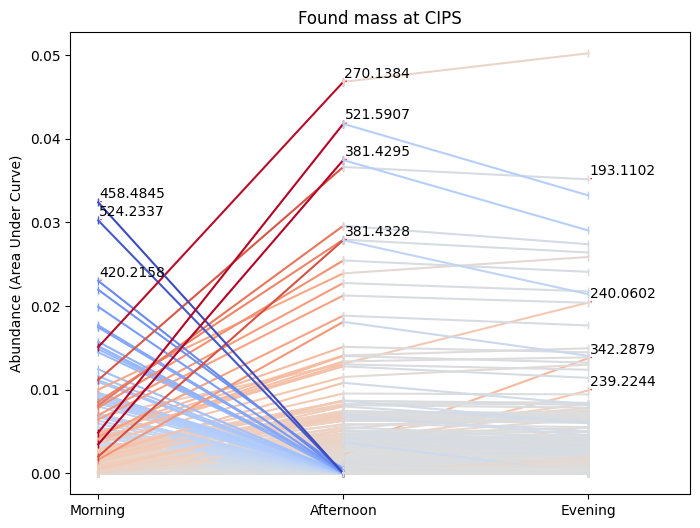

Processing 0-th mass for correlation
Processing 200-th mass for correlation
Processing 400-th mass for correlation
Processing 600-th mass for correlation


C:\Users\smrfaa\Anaconda3\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


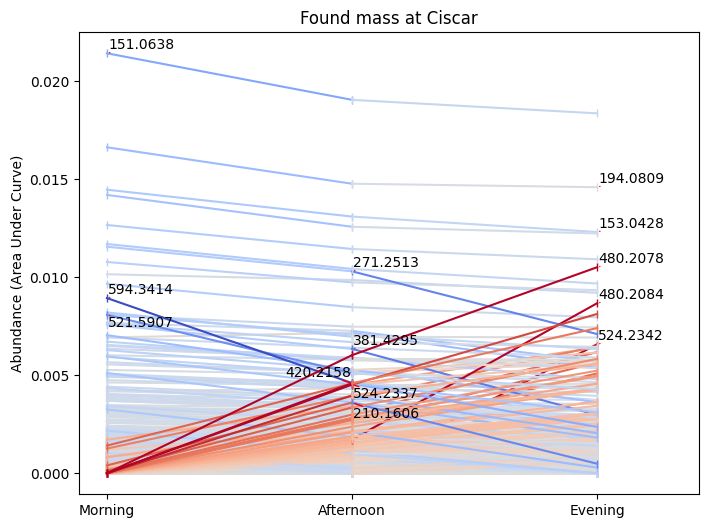

Processing 0-th mass for correlation
Processing 200-th mass for correlation
Processing 400-th mass for correlation
Processing 600-th mass for correlation
Processing 800-th mass for correlation
Processing 1000-th mass for correlation


C:\Users\smrfaa\Anaconda3\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


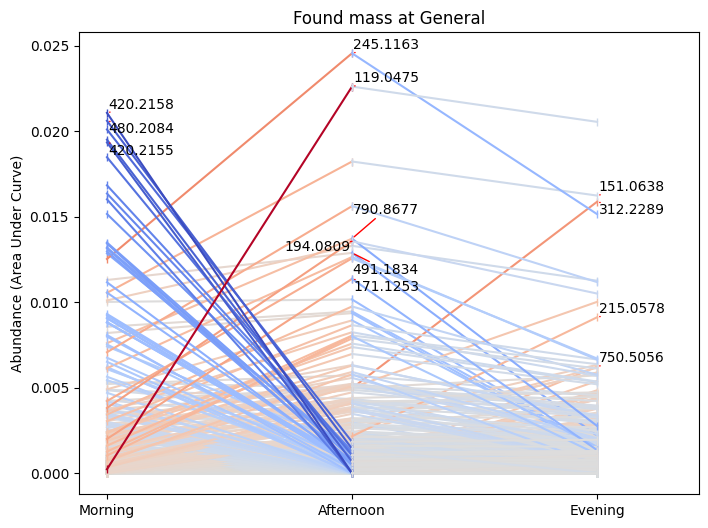

Processing 0-th mass for correlation
Processing 200-th mass for correlation
Processing 400-th mass for correlation
Processing 600-th mass for correlation
Processing 800-th mass for correlation
Processing 1000-th mass for correlation
Processing 1200-th mass for correlation
Processing 1400-th mass for correlation


C:\Users\smrfaa\Anaconda3\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


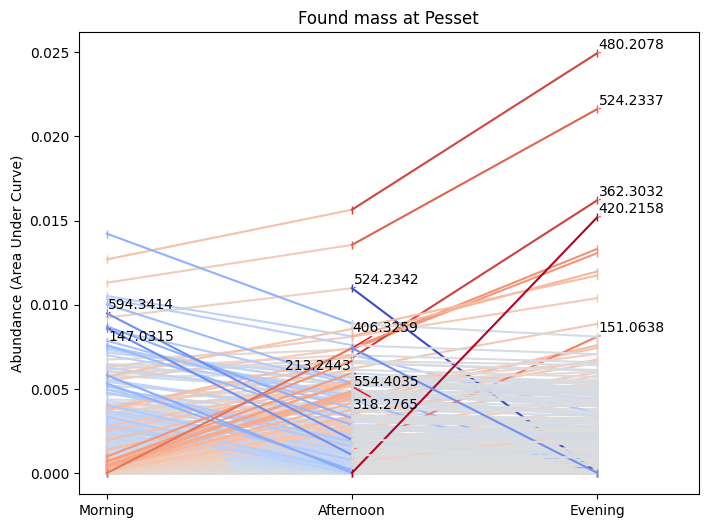

Processing 0-th mass for correlation
Processing 200-th mass for correlation
Processing 400-th mass for correlation
Processing 600-th mass for correlation
Processing 800-th mass for correlation
Processing 1000-th mass for correlation
Processing 1200-th mass for correlation
Processing 1400-th mass for correlation


C:\Users\smrfaa\Anaconda3\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [9]:
"""
for each source and location, plot a lineplot that tracks each individual chemical across time
each line should be coloured according to how much they increase/decrease
also need to label top 3 increasing and top 3 decreasing chemicals
"""
#loop for each location and source
for x in df.location.unique():
    
    #df preprocessing
    tmpdf = df[df.location == x]
    tmpdf = pd.pivot(tmpdf, index = 'found_mass', columns = 'time', values = 'auc').fillna(1)
    tmpdf[tmpdf<1] = 1
    
    tmpdf['avg'] = (tmpdf.Morning+tmpdf.Afternoon+tmpdf.Evening)/3
    tmpdf = tmpdf[tmpdf.avg > 1]
    
    summorn = sum(tmpdf.Morning)
    sumaft = sum(tmpdf.Afternoon)
    sumeve = sum(tmpdf.Evening)
    
    tmpdf.Morning = tmpdf.Morning/summorn
    tmpdf.Afternoon = tmpdf.Afternoon/sumaft
    tmpdf.Evening = tmpdf.Evening/sumeve
    
    tmpdf = tmpdf.drop(columns = ['avg'])
    
    #tmpdf.to_csv(f"{x}_abundance.csv")
    
    #for each chem color mapping
    eachchemdf = colour_mapping(tmpdf)
    
    #plotting lineplot
    eachchem_lineplot(eachchemdf, massdb)
    
    #calculating pearson correlation
    corrdf, corrdict = corr(tmpdf)
    
    #saving the corrdict
    out_file = open(f"figs/corrdict_{x}.json", "w")
    json.dump(corrdict, out_file, indent = 6)
    out_file.close()
    
    #NMDS and plotting
    cluster_dict = nmds(tmpdf, corrdf, massdb)
    
    #saving cluster_dict
    out_file = open(f"figs/clusterdict_{x}.json", "w")
    json.dump(cluster_dict, out_file, indent = 6)
    out_file.close()
    
    #plotting clustermap
    corr_clusterplot(corrdf)

In [ ]:
#to extract clustered
#loop for each location and source
for x in df.location.unique():

In [ ]:
tmpdf = df[df.location == 'Ciscar']
tmpdf = pd.pivot(tmpdf, index = 'found_mass', columns = 'time', values = 'auc').fillna(1)
tmpdf[tmpdf<1] = 1

tmpdf['avg'] = (tmpdf.Morning+tmpdf.Afternoon+tmpdf.Evening)/3
tmpdf = tmpdf[tmpdf.avg > 1]

summorn = sum(tmpdf.Morning)
sumaft = sum(tmpdf.Afternoon)
sumeve = sum(tmpdf.Evening)

tmpdf.Morning = tmpdf.Morning/summorn
tmpdf.Afternoon = tmpdf.Afternoon/sumaft
tmpdf.Evening = tmpdf.Evening/sumeve

tmpdf = tmpdf.drop(columns = ['avg'])

tmpdf

In [ ]:
x = 'Ciscar'

#for each chem color mapping
eachchemdf = colour_mapping(tmpdf)

#plotting lineplot
eachchem_lineplot(eachchemdf, massdb)

#calculating pearson correlation
corrdf, outdict = corr(tmpdf)

In [ ]:
corrdf1 = 1 - corrdf
corrnp1 = corrdf1.to_numpy()

corrnp1

In [ ]:
embedding = MDS(n_components=2, dissimilarity = 'precomputed', n_jobs = -1, max_iter = 10000, n_init = 12)
corrnp1_transform = embedding.fit_transform(corrnp1)

In [ ]:
tmpdf.loc[float(str(1382.8218)), 'Afternoon']

In [ ]:
testdict = {}
counter = 0

for xg in np.arange(0, 1, 0.05):
    xi = xg
    
    for sm in range(1, int(len(corrnp1)/30), 5):
        sample = sm
        opticslabel = OPTICS(min_samples = sample, cluster_method='xi', xi = xi, n_jobs = -1).fit_predict(corrnp1_transform)
        
        counter += 1
        
        testdict[f'test_{counter}'] = {'xi':xi, 'min_sample':sample, 'n_cluster':len(set(opticslabel))}
        
        if counter%50 == 0:
            print(f'Processing {counter}-th test')
        
optdf = pd.DataFrame.from_dict(testdict)

In [ ]:
embedding = MDS(n_components=2, dissimilarity = 'precomputed', n_jobs = -1, max_iter = 10000, n_init = 12)
corrnp1_transform = embedding.fit_transform(corrnp1)

opticslabel = OPTICS(min_samples=10, cluster_method='xi', xi = 0.5, algorithm = 'kd_tree').fit_predict(corrnp1_transform)

dfg = pd.DataFrame()

dfg['MDS1'] = corrnp1_transform[:, 0]
dfg['MDS2'] = corrnp1_transform[:, 1]
dfg['opticslabel'] = opticslabel
avgauc = (tmpdf.Morning + tmpdf.Afternoon + tmpdf.Evening)/3
dfg['avgauc'] = avgauc.values
dfg['found_mass'] = tmpdf.index

collim = dfg['opticslabel'].values
    
norm = colors.Normalize(vmin=min(collim), vmax=max(collim), clip=True)
mapper = cm.ScalarMappable(norm = norm, cmap=cm.tab20c)

dfg['mapped_color'] = [mapper.to_rgba(x) for x in opticslabel]

fig, ax = plt.subplots()
textsall = []

groupdict = {}

tolr = 10

for xx in set(dfg['opticslabel'].values):
    tmpdfg = dfg[dfg.opticslabel == xx]
    #mass = list(tmpdfg.nlargest(15, 'avgauc').found_mass)
    top5 = set(tmpdfg.nlargest(8, 'avgauc').found_mass)
    
    namelist = []
    for m in mass:
        for i in dbdict:
            if abs(float(dbdict[i]['neutral_mass']) - float(m)) <= tolr*float(m)/1e6 :
                namelist.append(dbdict[i]['name'])

    groupdict[f'Cluster_{xx}'] = namelist


    for index,row in tmpdfg.iterrows():
        xr = row.MDS1 
        yr = row.MDS2 
        
        if row.opticslabel == -1:
            xr = xr + np.random.randn() * 0.001
            yr = yr + np.random.randn() * 0.001
            ax.plot(xr, yr, marker = '.', alpha = 0.2, c = 'black', markersize = 0.5)
            
        else:
            ax.plot(xr, yr, marker = '.', alpha = 0.5, c = row.mapped_color)

            if row.found_mass in top5:
                label = row.found_mass
                textsall.append(ax.text(x = xr, y =  yr, s = label, fontsize = 4, c = row.mapped_color))    

adjust_text(textsall, force_points=(0.5,0.5), force_text=(0.2,0.2), arrowprops=dict(arrowstyle='-', linewidth = 0.1, color='black'), lim=500)

plt.savefig(f'figs/NMDS_spearmancorrelation_hoho.png', dpi = 600)
plt.close()

In [ ]:
set(opticslabel)

In [ ]:
sns.histplot(dfg.opticslabel)

In [ ]:
dfg[dfg.opticslabel == -1]

In [ ]:
npdata = tmpdf.to_numpy()

print(npdata)

#scale the AUC data first for downstream PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(npdata)

scldata = scaler.transform(npdata)
print(scldata)

#PCA
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(scldata)
scldata = pca.transform(scldata)

print(scldata)

plt.scatter(scldata[:, 0], scldata[:, 1])
plt.show()
plt.close()

In [ ]:
(tmpdf.Morning + tmpdf.Afternoon + tmpdf.Evening)/3

In [ ]:
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05, metric = 'minkowski')

#fit
clust.fit(npdata)

#plotting
fig,ax = plt.subplots(figsize=(10, 7))

colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = npdata[clust.labels_ == klass]
    ax.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax.plot(npdata[clust.labels_ == -1, 0], npdata[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nOPTICS")

In [ ]:
for x in df.location.unique():
    tmpdf = df[df.location == x]
    
    grouped_auc = tmpdf.groupby(by = ['time', 'chem_source'])['log10_auc'].mean()
    grouped_auc_sorted = sorted(grouped_auc)
    
    max_auc = max(grouped_auc)
    min_auc = min(grouped_auc)
    div5 = (max_auc - min_auc)/5
    Q1 = min_auc + div5*2
    Q2 = min_auc + div5*3
    Q3 = min_auc + div5*4
    
    # ------- PART 1: Create background

    # number of variable
    categories = tmpdf.chem_source.unique()
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise plot
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    labelname = [' \n Unknown', 'Plant derived', 'Cross kingdom', 'Animal derived', 'Fungus-derived',
                            'Human derived', 'Synthetic', 'Environment derived']
    
    labelname = ["\n".join(wrap(r, 5, break_long_words=False)) for r in labelname]

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], labelname)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([Q1,Q2,Q3], [f"{np.floor(Q1)}",f"{np.floor(Q2)}",f"{np.floor(Q3)}"], color="grey", size=7)
    plt.ylim(min_auc,max_auc)
    
    # ------- PART 2: Add plots
 
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable
    
    color = ['r', 'b', 'g']
    
    for h, y in enumerate(df.time.unique()):
        tmpdf2 = tmpdf[tmpdf.time == y]
        grouped_auc_2 = tmpdf2.groupby(by=['chem_source'])['log10_auc'].mean()
        
        values=grouped_auc_2.values.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{y}")
        ax.fill(angles, values, color[h], alpha=0.02)

        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.35))
    
    #legend editing
    XTICKS = ax.xaxis.get_major_ticks()
    for tick in XTICKS:
        tick.set_pad(17.5)
        
    plt.title(label = f'Location = {x}', position = (0.5, 1.8))

    # Show the graph
    plt.savefig(f'figs/spiderplot_{x}_{y}.png')
    plt.show()
    

In [ ]:
for x in df.time.unique():
    tmpdf = df[df.time == x]
    
    grouped_auc = tmpdf.groupby(by = ['location', 'chem_source'])['log10_auc'].mean()
    grouped_auc_sorted = sorted(grouped_auc)
    
    max_auc = max(grouped_auc)
    min_auc = min(grouped_auc)
    div5 = (max_auc - min_auc)/5
    Q1 = min_auc + div5*2
    Q2 = min_auc + div5*3
    Q3 = min_auc + div5*4
    
    # ------- PART 1: Create background

    # number of variable
    categories = tmpdf.chem_source.unique()
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise plot
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    labelname = [' \n Unknown', 'Plant derived', 'Cross kingdom', 'Animal derived', 'Fungus-derived',
                            'Human derived', 'Synthetic', 'Environment derived']
    
    labelname = ["\n".join(wrap(r, 5, break_long_words=False)) for r in labelname]

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], labelname)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([Q1,Q2,Q3], [f"{np.floor(Q1)}",f"{np.floor(Q2)}",f"{np.floor(Q3)}"], color="grey", size=7)
    plt.ylim(min_auc,max_auc)
    
    # ------- PART 2: Add plots
 
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable
    
    color = ['r', 'b', 'g', 'y']
    
    for h, y in enumerate(df.location.unique()):
        tmpdf2 = tmpdf[tmpdf.location == y]
        grouped_auc_2 = tmpdf2.groupby(by=['chem_source'])['log10_auc'].mean()
        
        values=grouped_auc_2.values.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{y}")
        ax.fill(angles, values, color[h], alpha=0.02)

        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.35))
    
    #legend editing
    XTICKS = ax.xaxis.get_major_ticks()
    for tick in XTICKS:
        tick.set_pad(17.5)
        
    plt.title(label = f'Time = {x}', position = (0.5, 1.8))

    # Show the graph
    plt.savefig(f'figs/spiderplot_{x}.png')
    plt.show()

In [ ]:
#relplot metabolome mass v auc

sns.relplot(data=df, x="found_mass", y="ln_auc", col= 'location', row = 'time', hue = 'location', 
            palette="plasma", kind="scatter")

plt.savefig('figs/scatter_mass_v_lnauc.png')

In [ ]:
#histplot metabolome 
g = sns.FacetGrid(df, col="location", hue = 'location', palette="plasma")

g.map(sns.histplot, 'time', 'chem_role')

plt.savefig('figs/hist_loctime_chemrole.png')

In [ ]:
#heatmap of metabolome for each location and different timing
column_order = ['Morning', 'Afternoon', 'Evening']

for x in df.location.unique():
    tmpdf = df[df.location == x]
    
    for y in ['chem_name','chem_tax_class', 'chem_source', 'chem_ont_bioprocess', 'chem_role', 'chem_class']:

        tmppt = pd.pivot_table(tmpdf, index=[y], values = 'ln_auc', columns = ['time'], aggfunc=np.sum).reindex(column_order, axis=1)
        
        hm_length = len(tmppt) * 0.4 #0.1 inch per protein
        hm_width = 12
        
        plt.figure(figsize=(hm_width,hm_length))
        
        cbar_len = {True: {"shrink": 0.5}, False: {"shrink": 0.9}}
        
        ax = sns.heatmap(tmppt, linewidth=.5, square = True, cbar_kws=cbar_len[len(tmppt)>10])
        
        ax.xaxis.set_label_text("")
        ax.yaxis.set_label_text("")
        
        plt.savefig(f'figs/heatmap_{x}_{y}.png')
        
        plt.show()